# XGBoost classifier on AK voter data

Question: Is voter party affiliation dependent on select socioeconomic factors, as well as demographic information?

Response Variable: Parties_Description

Predictors: CommercialData_EstimatedHHIncome, Ethnic_Description, Voters_gender, CommercialData_EstHomeValue, CommercialData_Education, Voters_age, CommercialData_OccupationGroup


In [ ]:
# import packages
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
# load the data (change to google cloud storage)
df = pd.read_csv(r"C:\Users\ivani\Downloads\AK-voterfile.csv")

'''
# convert a Spark DataFrame to pandas
spark_df = spark.read.format("delta").load("/mnt/delta/AK-voterfile")
df = spark_df.toPandas()
'''

C:\Users\ivani\AppData\Local\Temp\ipykernel_23108\2606535263.py:2: DtypeWarning: Columns (22,26,50,144,218,219,221,222,240,241,243,244,262,263,265,266,285,290,354,355,356,357,358,359,360,361,370,371) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\ivani\Downloads\AK-voterfile.csv")


'\n# convert a Spark DataFrame to pandas\nspark_df = spark.read.format("delta").load("/mnt/delta/AK-voterfile")\ndf = spark_df.toPandas()\n'

# Data pre-processing for XGBoost model

Converting predictor columns to numeric, categorical, and binary when applicable

In [ ]:
# Filter out rows where Parties_Description is either "Unknown" or "Other"
df = df[~df["Parties_Description"].isin(["Unknown", "Other"])]

# Subset columns of interest and target variable
X = df[["CommercialData_EstimatedHHIncome", "Ethnic_Description", 
        "Voters_Gender", "CommercialData_EstHomeValue", 
        "CommercialData_Education", "Voters_Age", "CommercialData_OccupationGroup"]]
y = df["Parties_Description"]

# Drop rows with missing predictor values and update y accordingly
X = X.dropna()
y = y.loc[X.index]

# randomly undersample the republican class
democratic_count = y.value_counts().get('Democratic', 0)
republican_count = y.value_counts().get('Republican', 0)

republican_indices = y[y == 'Republican'].index
undersampled_republican_indices = np.random.choice(republican_indices, democratic_count, replace=False)
X = X.drop(undersampled_republican_indices)
y = y.drop(undersampled_republican_indices)

# Encode party description into numeric labels
y = y.map({
    'Constitution': 0,
    'Democratic': 1,
    'Green Libertarian': 2,
    'Independence': 3,
    'Libertarian': 4,
    'Republican': 5,
    'Non-Partisan': 6
})

# Convert Voters_Gender to binary
X['Voters_Gender'] = X['Voters_Gender'].map({'F': 0, 'M': 1})

# Convert CommercialData_EstHomeValue to numeric
X['CommercialData_EstHomeValue'] = X['CommercialData_EstHomeValue'].replace({'\$': ''}, regex=True).astype(float) # strip $ sign
X['CommercialData_EstHomeValue'] = pd.to_numeric(X['CommercialData_EstHomeValue'])

# Convert Ethnic_Description to categorical
X["Ethnic_Description"] = X["Ethnic_Description"].astype('category')

# Convert Voters_Age to numeric with error coercion
X['Voters_Age'] = pd.to_numeric(X['Voters_Age'], errors='coerce')

# Convert other relevant columns to categorical
X["CommercialData_OccupationGroup"] = X["CommercialData_OccupationGroup"].astype('category')
X["CommercialData_EstimatedHHIncome"] = X["CommercialData_EstimatedHHIncome"].astype('category')
X["CommercialData_Education"] = X["CommercialData_Education"].astype('category')

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

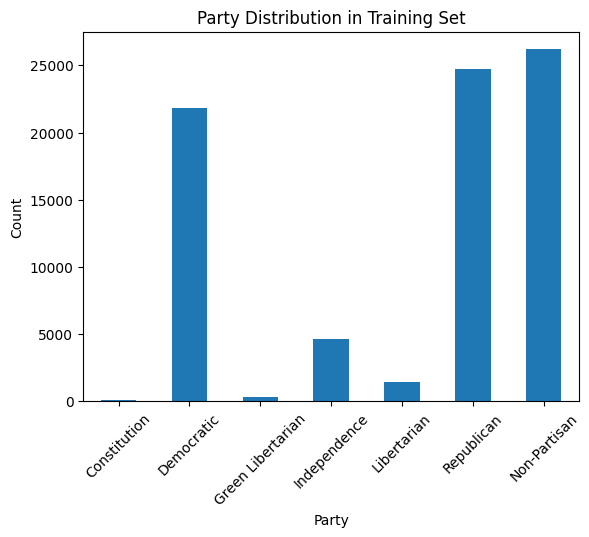

In [134]:
# Get the party counts sorted by encoded value
party_counts = y.value_counts().sort_index()

# Define the mapping for labels
label_mapping = {
    0: 'Constitution',
    1: 'Democratic',
    2: 'Green Libertarian',
    3: 'Independence',
    4: 'Libertarian',
    5: 'Republican',
    6: 'Non-Partisan'
}

# Create a list of labels in sorted order (0 through 8)
labels = [label_mapping[i] for i in sorted(party_counts.index)]

# Plot the distribution using the sorted counts
party_counts.plot(kind='bar', title='Party Distribution in Training Set')

# Set the x-axis ticks and labels
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45)
plt.xlabel('Party')
plt.ylabel('Count')
plt.show()

# XGBoost Model Training

- 5 fold cross validation
- Binary logistic loss function
- Grid search to find best parameters

In [135]:
# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200]
}

# define GridSearchCV, using accuracy as the scoring metric
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\ivani\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:34:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

# XGBoost model evaluation
Here, the following will be assessed
- Classification report of the best XGBoost model on the test set
- Confusion Matrix Visualization
- Feature Importance Visualization

In [136]:
# print classification report

# make predictions on the test set
y_pred = grid_search.predict(X_test)

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.40      0.31      0.35      4403
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00       890
           4       0.00      0.00      0.00       271
           5       0.38      0.45      0.41      4946
           6       0.37      0.46      0.41      5279

    accuracy                           0.38     15847
   macro avg       0.16      0.17      0.17     15847
weighted avg       0.35      0.38      0.36     15847



c:\Users\ivani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [137]:
# Evaluate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.3779264214046823


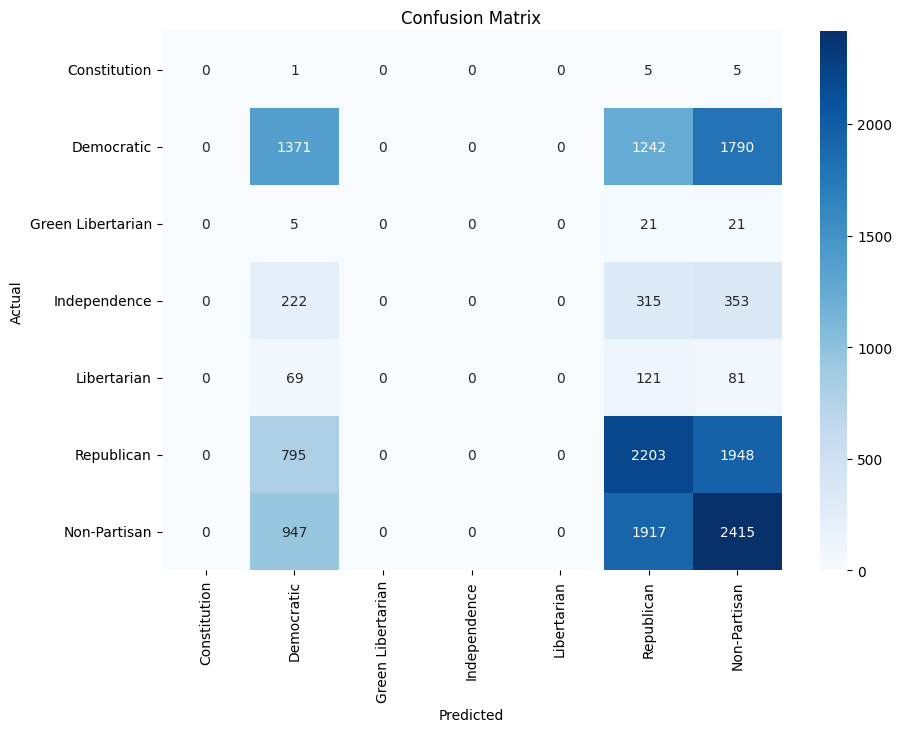

In [138]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# plot confusion matrix
# Define a mapping from encoded values to party labels.
label_mapping = {
    0: 'Constitution',
    1: 'Democratic',
    2: 'Green Libertarian',
    3: 'Independence',
    4: 'Libertarian',
    5: 'Republican',
    6: 'Non-Partisan'
}

# Create a sorted list of labels
labels = [label_mapping[i] for i in sorted(label_mapping.keys())]

# plot confusion matrix with proper labels on both axes
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [143]:
confusion_matrix_df

,Constitution,Democratic,Green Libertarian,Independence,Libertarian,Republican,Non-Partisan
Constitution,0,1,0,0,0,5,5
Democratic,0,1371,0,0,0,1242,1790
Green Libertarian,0,5,0,0,0,21,21
Independence,0,222,0,0,0,315,353
Libertarian,0,69,0,0,0,121,81
Republican,0,795,0,0,0,2203,1948
Non-Partisan,0,947,0,0,0,1917,2415


We see that the model most often predicts the Republican and Non-Partisan parties, misclassifying the other classes often. In the confusion matrix, many observations that belong to the Democratic, Independence, or Libertarian groups are misclassified as Republican or Non-Partisan. This suggests that the model has a strong bias toward predicting these classes, possibly due to the imbalanced class distribution, overlapping feature patterns, or insufficient discriminatory information among the predictors, which limits its ability to accurately distinguish between the less frequently predicted classes.

In [139]:
# print best parameters from grid search
print("Best Parameters from Grid Search:", grid_search.best_params_)

Best Parameters from Grid Search: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


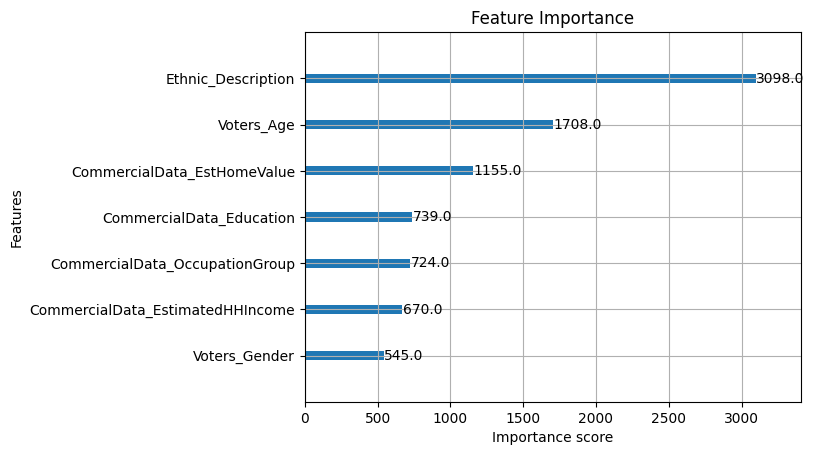

In [141]:
# importance plot
import matplotlib.pyplot as plt
xgb.plot_importance(grid_search.best_estimator_, importance_type='weight')
plt.title('Feature Importance')
plt.show()

We see that the most important feature in the best XGBoost model was Ethnic Description. Due to the nature of tree models, the feature importance is not directly interpretable. It only provides a relative ranking of variables based on their frequency (or gain/cover) in the model's splits, and does not offer direct insights into the magnitude or causal effect of each feature on the predictions.

Overall, the model is not very impressive, but performs better than random chance. Similar results were also observed when randomly undersampling different parties to obtain balanced classes, as well as leaving the class distribution as is. In conclusion, voter party affiliation is reliant on more than just the 7 chosen factors.